In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import os
%matplotlib inline

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [3]:
def readData():
    train = pd.read_csv("data.csv")
    return train

In [4]:
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [5]:
# Augment Features
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [6]:
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [7]:
from sklearn import preprocessing
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [8]:
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [9]:
def shuffle1(X,Y):
  np.random.seed()
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [10]:
# 將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [11]:
def buildModel(shape):
    adam=Adam(lr=0.002)
    model = Sequential()
    model.add(LSTM(128, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(9)) 
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
'''
def buildModel(shape):
    model = Sequential()
    model.add(Dense(250, input_dim=shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(250))
    model.add(Activation('relu'))
    model.add(Dense(9))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
'''

'\ndef buildModel(shape):\n    model = Sequential()\n    model.add(Dense(250, input_dim=shape[1]))\n    model.add(Activation(\'relu\'))\n    model.add(Dense(250))\n    model.add(Activation(\'relu\'))\n    model.add(Dense(9))\n    model.add(Activation(\'softmax\'))\n    model.compile(loss="categorical_crossentropy", optimizer=\'adam\',metrics=[\'accuracy\'])\n    model.summary()\n    return model\n'

In [12]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [13]:
'''
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle1(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
model.fit(train_x, train_y, epochs=300, batch_size=256, verbose=2,validation_split=0.1, callbacks=[history])
'''
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle1(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(1, 8))`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            70144     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0         
Total params: 202,889
Trainable params: 202,889
Non-trainable params: 0
_________________________________________________________________
Train on 5013 samples, validate on 558 samples
Epoch 1/300
 - 2s - loss: 2.1591 - acc: 0.2296 - val_loss: 2.0888 - val_acc: 0.2366
Epoch 2/300
 - 0s - loss: 2.0171 - acc: 0.2372 - val_loss: 1.9999 - val_acc: 0.2348
Epoch 3/300
 - 0s - loss: 1.9814 - acc: 0.2370 - val_

Epoch 87/300
 - 0s - loss: 1.9507 - acc: 0.2486 - val_loss: 1.9820 - val_acc: 0.2276
Epoch 88/300
 - 0s - loss: 1.9504 - acc: 0.2476 - val_loss: 1.9811 - val_acc: 0.2276
Epoch 89/300
 - 0s - loss: 1.9496 - acc: 0.2501 - val_loss: 1.9810 - val_acc: 0.2258
Epoch 90/300
 - 0s - loss: 1.9492 - acc: 0.2480 - val_loss: 1.9793 - val_acc: 0.2258
Epoch 91/300
 - 0s - loss: 1.9495 - acc: 0.2482 - val_loss: 1.9763 - val_acc: 0.2276
Epoch 92/300
 - 0s - loss: 1.9485 - acc: 0.2484 - val_loss: 1.9776 - val_acc: 0.2258
Epoch 93/300
 - 0s - loss: 1.9485 - acc: 0.2488 - val_loss: 1.9790 - val_acc: 0.2240
Epoch 94/300
 - 0s - loss: 1.9476 - acc: 0.2507 - val_loss: 1.9795 - val_acc: 0.2240
Epoch 95/300
 - 0s - loss: 1.9469 - acc: 0.2480 - val_loss: 1.9780 - val_acc: 0.2276
Epoch 96/300
 - 0s - loss: 1.9467 - acc: 0.2507 - val_loss: 1.9781 - val_acc: 0.2294
Epoch 97/300
 - 0s - loss: 1.9470 - acc: 0.2501 - val_loss: 1.9817 - val_acc: 0.2222
Epoch 98/300
 - 0s - loss: 1.9460 - acc: 0.2525 - val_loss: 1.979

Epoch 183/300
 - 0s - loss: 1.6383 - acc: 0.3583 - val_loss: 1.6946 - val_acc: 0.3280
Epoch 184/300
 - 0s - loss: 1.6392 - acc: 0.3631 - val_loss: 1.6677 - val_acc: 0.3495
Epoch 185/300
 - 0s - loss: 1.6321 - acc: 0.3639 - val_loss: 1.7503 - val_acc: 0.3315
Epoch 186/300
 - 0s - loss: 1.6378 - acc: 0.3639 - val_loss: 1.6804 - val_acc: 0.3441
Epoch 187/300
 - 0s - loss: 1.6298 - acc: 0.3553 - val_loss: 1.6846 - val_acc: 0.3477
Epoch 188/300
 - 0s - loss: 1.6259 - acc: 0.3658 - val_loss: 1.6564 - val_acc: 0.3674
Epoch 189/300
 - 0s - loss: 1.6187 - acc: 0.3676 - val_loss: 1.6671 - val_acc: 0.3351
Epoch 190/300
 - 0s - loss: 1.6235 - acc: 0.3637 - val_loss: 1.6855 - val_acc: 0.3423
Epoch 191/300
 - 0s - loss: 1.6248 - acc: 0.3625 - val_loss: 1.6871 - val_acc: 0.3333
Epoch 192/300
 - 0s - loss: 1.6140 - acc: 0.3649 - val_loss: 1.6587 - val_acc: 0.3566
Epoch 193/300
 - 0s - loss: 1.6127 - acc: 0.3746 - val_loss: 1.6524 - val_acc: 0.3495
Epoch 194/300
 - 0s - loss: 1.6109 - acc: 0.3736 - val

Epoch 279/300
 - 0s - loss: 1.5360 - acc: 0.4053 - val_loss: 1.6549 - val_acc: 0.3656
Epoch 280/300
 - 0s - loss: 1.5350 - acc: 0.3950 - val_loss: 1.6040 - val_acc: 0.3799
Epoch 281/300
 - 0s - loss: 1.5388 - acc: 0.3994 - val_loss: 1.6217 - val_acc: 0.3817
Epoch 282/300
 - 0s - loss: 1.5369 - acc: 0.3974 - val_loss: 1.7565 - val_acc: 0.3262
Epoch 283/300
 - 0s - loss: 1.5539 - acc: 0.3886 - val_loss: 1.6267 - val_acc: 0.3817
Epoch 284/300
 - 0s - loss: 1.5275 - acc: 0.4008 - val_loss: 1.6035 - val_acc: 0.3763
Epoch 285/300
 - 0s - loss: 1.5335 - acc: 0.3968 - val_loss: 1.6134 - val_acc: 0.3817
Epoch 286/300
 - 0s - loss: 1.5272 - acc: 0.3944 - val_loss: 1.6391 - val_acc: 0.3746
Epoch 287/300
 - 0s - loss: 1.5374 - acc: 0.3944 - val_loss: 1.6657 - val_acc: 0.3423
Epoch 288/300
 - 0s - loss: 1.5388 - acc: 0.3984 - val_loss: 1.6150 - val_acc: 0.3746
Epoch 289/300
 - 0s - loss: 1.5219 - acc: 0.3972 - val_loss: 1.5969 - val_acc: 0.3835
Epoch 290/300
 - 0s - loss: 1.5260 - acc: 0.3996 - val

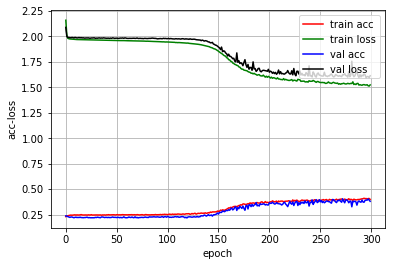

In [14]:
history.loss_plot('epoch')

In [15]:
loss, accuracy = model.evaluate(test_x, test_y)

print('test loss: ', loss)
print('test accuracy: ', accuracy)

618/618 [==============================] - 0s 47us/step
test loss:  1.6458642521336626
test accuracy:  0.3883495145631068
